In [1]:
# CONSTANTS
TECH_FS_WORKDIR = '../'
DATA_PRIMARY = TECH_FS_WORKDIR + 'data/primary/'
DATA_PRIMARY_TRAIN = DATA_PRIMARY + 'train_data.csv'
DATA_PRIMARY_TEST = DATA_PRIMARY + 'test_data.csv'
DATA_PRIMARY_SUBMISSION = DATA_PRIMARY + 'sample_submission.csv'

DATA_SECONDARY = TECH_FS_WORKDIR + 'data/secondary/'
DATA_PRIMARY_SUBMISSION_PATTERN = DATA_SECONDARY + 'daniels_submission_{dtime}.{filetype}'

DF_TARGET = 'cancer_type'
DF_FEATURES = None

TECH_DATE_FORMAT_DATE_DATASET = '%Y-%m-%d'
TECH_DATE_FORMAT_DATE_STD = '%Y%m%d_%H%M%S'

DF_TRAIN_TEST_SPLIT = 0.3
TECH_RANDOM_SEED = 1337
TECH_ARCH_CPU_CORES = 15 # 16 minus one for the OS

In [2]:
# IMPORTS
# regular Python imports
import os
import time
from warnings import filterwarnings
from datetime import datetime
from calendar import timegm

import pandas as pd
import numpy as np
import statistics
from tqdm import tqdm

import lightgbm as lgb
from lightgbm import LGBMRegressor

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
import matplotlib.pyplot as plt
from matplotlib import pyplot
from plotly import graph_objs

import shap
from xgboost import XGBClassifier

# scikit-learn imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# explicitly require experimental features
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


In [3]:
# STATIC METHODS
def get_timestamp_since_epoch(timestamp_date,
                              pattern=TECH_DATE_FORMAT_DATE_DATASET):
    if None == timestamp_date:
        return -1
    
    return timegm(time.strptime(timestamp_date, pattern))

def get_current_time_in_std_format(dtime=None, dateformat=TECH_DATE_FORMAT_DATE_STD):
    d = datetime.utcnow()
    if None != dtime:
        d = dtime
    return d.strftime(dateformat)

def get_translated_pipeline_parameter_by_number(no=None):
    if None is not no:
        if 0 == no:
            return 'simplistic'
        if 1 == no:
            return 'w/ dimensionality reduction'
        if 2 == no:
            return 'w/ feature selector'
    return no

def get_translated_model_by_number(no=None):
    if None is not no:
        if 0 == no:
            return 'Logistic Regression'
        if 1 == no:
            return 'XGBoost'
        if 2 == no:
            return 'Random Forest'
    return no

def save_df_table(df=None,
                  target_filename=None,
                  dtime=None,
                  include_index=True):
    if None is not df:
        dtm = get_current_time_in_std_format()
        target_filename_csv = DATA_PRIMARY_SUBMISSION_PATTERN.format(dtime=dtm, filetype='csv')
        target_filename_parquet = DATA_PRIMARY_SUBMISSION_PATTERN.format(dtime=dtm, filetype='parquet')
        
        res_csv = f'The resulting file will be saved to \"{target_filename_csv}\".'
        res_parquet = f'The resulting file will be saved to \"{target_filename_parquet}\".'
        
        # persist
        df.to_csv(path_or_buf=target_filename_csv, index=include_index)
        df.to_parquet(fname=target_filename_parquet, index=include_index)
        
        return (True, res_csv, res_parquet)
    return (False, None, None)

def save_df_submission(df=None,
                       target_filename=None,
                       dtime=None):
    return save_df_table(df=df,
                         target_filename=target_filename,
                         dtime=dtime,
                         include_index=False)

In [4]:
# Jupyter-related notebook settings
pd.set_option('display.max_rows', 512)

init_notebook_mode(connected=True)

# hide warnings -- sic: this is dangerous and must be revised before going to production
# TODO: review before PROD
filterwarnings('ignore')

In [5]:
d_train = pd.read_csv(DATA_PRIMARY_TRAIN)
d_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 13 columns):
radius_0          398 non-null float64
texture_0         398 non-null float64
perimeter_0       398 non-null float64
radius_1          343 non-null float64
texture_1         398 non-null float64
perimeter_1       264 non-null float64
radius_2          398 non-null float64
texture_2         398 non-null object
perimeter_2       398 non-null float64
age               398 non-null int64
treatment_date    398 non-null object
diagnose_date     398 non-null object
cancer_type       398 non-null int64
dtypes: float64(8), int64(2), object(3)
memory usage: 40.5+ KB


In [6]:
d_train['treatment_date'] = d_train['treatment_date'].apply(lambda d: get_timestamp_since_epoch(d))
d_train['diagnose_date'] = d_train['diagnose_date'].apply(lambda d: get_timestamp_since_epoch(d))

d_train['time_delta'] = d_train['treatment_date'] - d_train['diagnose_date']

# labeled types (benign/malignant) do not need to be re-labeled
# d_train[DF_TARGET] = d_train[DF_TARGET].apply(lambda v: True if 1 == v else False)

In [7]:
d_train.head()

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age,treatment_date,diagnose_date,cancer_type,time_delta
0,19.858394,27.204437,136.324256,22.683290,32.802578,119.523841,21.477052,27.3070874472,82.366936,44,1149292800,1130025600,0,19267200
1,14.182069,15.754730,80.916983,14.043753,30.094704,94.911073,15.012329,17.8551305385,103.078286,59,1077408000,1187568000,1,-110160000
2,25.380268,21.291553,152.281062,23.852166,46.237931,NaN,28.563252,21.0971528265,143.367792,37,1136505600,1091836800,0,44668800
3,11.835961,17.820702,72.178523,11.260258,44.805167,NaN,12.082749,16.4992370844,65.920413,51,1050278400,1118880000,1,-68601600
4,14.875600,17.534187,98.545830,14.380683,26.190447,89.712492,12.930685,19.8566873539,108.380754,21,1087776000,1038355200,1,49420800


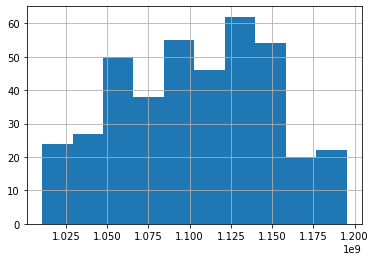

In [8]:
d_train['diagnose_date'].hist()

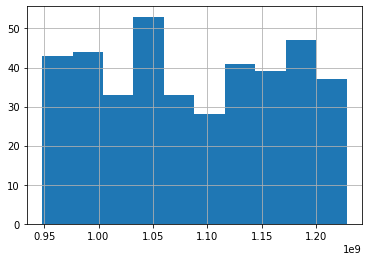

In [9]:
d_train['treatment_date'].hist()

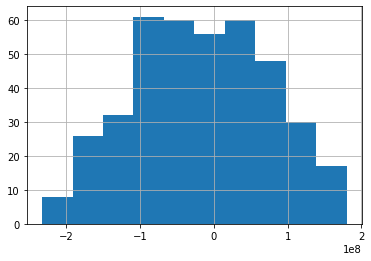

In [10]:
d_train['time_delta'].hist()

In [11]:
if None == DF_FEATURES:
    DF_FEATURES = list(d_train.columns)
    DF_FEATURES.remove(DF_TARGET)
DF_FEATURES

['radius_0',
 'texture_0',
 'perimeter_0',
 'radius_1',
 'texture_1',
 'perimeter_1',
 'radius_2',
 'texture_2',
 'perimeter_2',
 'age',
 'treatment_date',
 'diagnose_date',
 'time_delta']

In [12]:
d_train.isna().sum()
# almost identical to: d_train.isnull().sum()

radius_0            0
texture_0           0
perimeter_0         0
radius_1           55
texture_1           0
perimeter_1       134
radius_2            0
texture_2           0
perimeter_2         0
age                 0
treatment_date      0
diagnose_date       0
cancer_type         0
time_delta          0
dtype: int64

In [13]:
f'Currently, there are {sum(d_train.isna().sum())} NA/missing values in the \"d_train\" DataFrame.'

'Currently, there are 189 NA/missing values in the "d_train" DataFrame.'

In [14]:
d_train['texture_2'] = pd.to_numeric(d_train['texture_2'], errors='coerce')

In [15]:
d_train

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age,treatment_date,diagnose_date,cancer_type,time_delta
0,19.858394,27.204437,136.324256,22.683290,32.802578,119.523841,21.477052,27.307087,82.366936,44,1149292800,1130025600,0,19267200
1,14.182069,15.754730,80.916983,14.043753,30.094704,94.911073,15.012329,17.855131,103.078286,59,1077408000,1187568000,1,-110160000
2,25.380268,21.291553,152.281062,23.852166,46.237931,NaN,28.563252,21.097153,143.367792,37,1136505600,1091836800,0,44668800
3,11.835961,17.820702,72.178523,11.260258,44.805167,NaN,12.082749,16.499237,65.920413,51,1050278400,1118880000,1,-68601600
4,14.875600,17.534187,98.545830,14.380683,26.190447,89.712492,12.930685,19.856687,108.380754,21,1087776000,1038355200,1,49420800
5,11.016351,24.013399,72.373560,12.074242,41.714316,71.440328,11.308987,NaN,73.637586,27,1215993600,1051315200,1,164678400
6,19.379444,21.850345,107.734027,16.748725,22.265567,NaN,18.089348,20.962623,184.390751,51,1193097600,1127260800,0,65836800
7,14.292161,28.430808,81.293588,15.042501,36.480522,78.668608,14.584187,24.055640,126.014415,40,1051401600,1113868800,1,-62467200
8,13.119916,14.619103,88.293516,13.093215,12.299673,81.907981,13.963749,16.908342,56.235029,43,1110240000,1131321600,1,-21081600
9,15.100628,7.440004,90.024419,14.645858,11.425323,95.242578,13.570790,11.934938,139.979154,50,956448000,1144368000,1,-187920000


In [16]:
d_train.isna().sum()
# almost identical to: d_train.isnull().sum()

radius_0            0
texture_0           0
perimeter_0         0
radius_1           55
texture_1           0
perimeter_1       134
radius_2            0
texture_2          16
perimeter_2         0
age                 0
treatment_date      0
diagnose_date       0
cancer_type         0
time_delta          0
dtype: int64

In [17]:
f'Currently, there are {sum(d_train.isna().sum())} NA/missing values in the \"d_train\" DataFrame.'

'Currently, there are 205 NA/missing values in the "d_train" DataFrame.'

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(d_train[DF_FEATURES],
                                                  d_train[DF_TARGET],
                                                  test_size=DF_TRAIN_TEST_SPLIT,
                                                  random_state=TECH_RANDOM_SEED)

In [19]:
imputer_simple = SimpleImputer(missing_values=np.nan)
# imputer_missing = MissingIndicator(missing_values=np.nan)
# imputer_iterative = IterativeImputer(missing_values=np.nan)
imputers = [imputer_simple]
impute_strategies = ['mean', 'median', 'most_frequent']

dimreduce_pca = PCA()
# dimreduce_tsne = TSNE()
dimreducers = [dimreduce_pca]

selector_kbest = SelectKBest()
# selector_varthres = VarianceThreshold()
# selector_chi2 = chi2()
selectors = [selector_kbest]

classifier_logistic = [LogisticRegression()]
# classifiers_svm = LogisticRegression()
classifiers_xgboost = [XGBClassifier()]
classifier_xgboost_estimators = [10, 100, 500] # [10, 100, 1000]
classifier_xgboost_depth = [3, 5, 10]
classifier_xgboost_lr = [0.1, 0.01]

classifier_rf = [RandomForestClassifier()]
classifier_rf_estimators = classifier_xgboost_estimators # [10, 100, 1000]
classifier_rf_depth = classifier_xgboost_depth


In [20]:
range_features_col_count = range(1, len(X_train.columns))
range_features_col_count

range(1, 13)

In [21]:
d_test = pd.read_csv(DATA_PRIMARY_TEST)
d_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 12 columns):
radius_0          171 non-null float64
texture_0         171 non-null float64
perimeter_0       171 non-null float64
radius_1          146 non-null float64
texture_1         171 non-null float64
perimeter_1       105 non-null float64
radius_2          171 non-null float64
texture_2         171 non-null object
perimeter_2       171 non-null float64
age               171 non-null int64
treatment_date    171 non-null object
diagnose_date     171 non-null object
dtypes: float64(8), int64(1), object(3)
memory usage: 16.2+ KB


In [22]:
d_test.head()

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age,treatment_date,diagnose_date
0,12.567724,13.561447,77.106898,10.773643,45.494416,NaN,12.526989,15.7063580493,123.583682,31,2008-11-19,2003-04-22
1,11.195949,19.693575,81.244301,15.058411,7.909249,86.766622,13.728960,21.485344712,154.164201,18,2001-08-18,2003-07-07
2,15.712720,26.114134,90.977022,13.832857,18.086143,NaN,14.758324,27.0205254475,114.023403,43,2006-11-17,2004-03-06
3,13.428698,26.649458,76.456016,14.837875,6.122950,89.609565,16.279206,29.1837924649,199.756098,57,2001-01-10,2006-02-24
4,179.763472,14.175435,51.125047,NaN,21.116416,52.041704,9.191477,13.5857306814,74.879232,26,2008-07-12,2004-06-21


In [23]:
d_test['texture_2'] = pd.to_numeric(d_test['texture_2'], errors='coerce')

In [24]:
d_test['treatment_date'] = d_test['treatment_date'].apply(lambda d: get_timestamp_since_epoch(d))
d_test['diagnose_date'] = d_test['diagnose_date'].apply(lambda d: get_timestamp_since_epoch(d))

d_test['time_delta'] = d_test['treatment_date'] - d_test['diagnose_date']

# labeled types (benign/malignant) do not need to be re-labeled
# d_test[DF_TARGET] = d_test[DF_TARGET].apply(lambda v: True if 1 == v else False)

In [25]:
d_test.head()

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age,treatment_date,diagnose_date,time_delta
0,12.567724,13.561447,77.106898,10.773643,45.494416,NaN,12.526989,15.706358,123.583682,31,1227052800,1050969600,176083200
1,11.195949,19.693575,81.244301,15.058411,7.909249,86.766622,13.728960,21.485345,154.164201,18,998092800,1057536000,-59443200
2,15.712720,26.114134,90.977022,13.832857,18.086143,NaN,14.758324,27.020525,114.023403,43,1163721600,1078531200,85190400
3,13.428698,26.649458,76.456016,14.837875,6.122950,89.609565,16.279206,29.183792,199.756098,57,979084800,1140739200,-161654400
4,179.763472,14.175435,51.125047,NaN,21.116416,52.041704,9.191477,13.585731,74.879232,26,1215820800,1087776000,128044800


In [26]:
d_test.isna().sum()
# almost identical to: d_test.isnull().sum()

radius_0           0
texture_0          0
perimeter_0        0
radius_1          25
texture_1          0
perimeter_1       66
radius_2           0
texture_2         12
perimeter_2        0
age                0
treatment_date     0
diagnose_date      0
time_delta         0
dtype: int64

In [27]:
f'Currently, there are {sum(d_test.isna().sum())} NA/missing values in the \"d_test\" DataFrame.'

'Currently, there are 103 NA/missing values in the "d_test" DataFrame.'

In [28]:
X_test = d_test[DF_FEATURES]

In [29]:
X_test.head()

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age,treatment_date,diagnose_date,time_delta
0,12.567724,13.561447,77.106898,10.773643,45.494416,NaN,12.526989,15.706358,123.583682,31,1227052800,1050969600,176083200
1,11.195949,19.693575,81.244301,15.058411,7.909249,86.766622,13.728960,21.485345,154.164201,18,998092800,1057536000,-59443200
2,15.712720,26.114134,90.977022,13.832857,18.086143,NaN,14.758324,27.020525,114.023403,43,1163721600,1078531200,85190400
3,13.428698,26.649458,76.456016,14.837875,6.122950,89.609565,16.279206,29.183792,199.756098,57,979084800,1140739200,-161654400
4,179.763472,14.175435,51.125047,NaN,21.116416,52.041704,9.191477,13.585731,74.879232,26,1215820800,1087776000,128044800


In [30]:
parameters_simple = [
    {
        'imp': imputers,
        'imp__strategy': impute_strategies,
        'classify': classifier_logistic
    },
    {
        'imp': imputers,
        'imp__strategy': impute_strategies,
        'classify': classifiers_xgboost,
        'classify__n_estimators': classifier_xgboost_estimators,
        'classify__n_max_depth': classifier_xgboost_depth,
        'classify__n_learning_rate': classifier_xgboost_lr,
        'classify__random_state': [TECH_RANDOM_SEED]
    },
    {
        'imp': imputers,
        'imp__strategy': impute_strategies,
        'classify': classifier_rf,
        'classify__n_estimators': classifier_rf_estimators,
        'classify__max_depth': classifier_rf_depth,
        'classify__random_state': [TECH_RANDOM_SEED]
    }
]

parameters_dimred = [
    {
        'imp': imputers,
        'imp__strategy': impute_strategies,
        'reduce_dim': dimreducers,
        'reduce_dim__n_components': range_features_col_count,
        'classify': classifier_logistic
    },
    {
        'imp': imputers,
        'imp__strategy': impute_strategies,
        'classify': classifiers_xgboost,
        'classify__n_estimators': classifier_xgboost_estimators,
        'classify__n_max_depth': classifier_xgboost_depth,
        'classify__n_learning_rate': classifier_xgboost_lr,
        'classify__random_state': [TECH_RANDOM_SEED]
    },
    {
        'imp': imputers,
        'imp__strategy': impute_strategies,
        'reduce_dim': dimreducers,
        'reduce_dim__n_components': range_features_col_count,
        'classify': classifier_rf,
        'classify__n_estimators': classifier_rf_estimators,
        'classify__random_state': [TECH_RANDOM_SEED]
    }
]

parameters_selector = [
    {
        'imp': imputers,
        'imp__strategy': impute_strategies,
        'feat_select': selectors,
        'feat_select__k': range_features_col_count,
        'classify': classifier_logistic
    },
    {
        'imp': imputers,
        'imp__strategy': impute_strategies,
        'classify': classifiers_xgboost,
        'classify__n_estimators': classifier_xgboost_estimators,
        'classify__n_max_depth': classifier_xgboost_depth,
        'classify__n_learning_rate': classifier_xgboost_lr,
        'classify__random_state': [TECH_RANDOM_SEED]
    },
    {
        'imp': imputers,
        'imp__strategy': impute_strategies,
        'feat_select': selectors,
        'feat_select__k': range_features_col_count,
        'classify': classifier_rf,
        'classify__n_estimators': classifier_rf_estimators,
        'classify__max_depth': classifier_rf_depth,
        'classify__random_state': [TECH_RANDOM_SEED]
    }
]

pipeline_simple = Pipeline(
    [ 
        ('imp', 'passthrough'), 
        ('classify', 'passthrough')
    ])

pipeline_dimred = Pipeline(
    [ 
        ('imp', 'passthrough'), 
        ('reduce_dim', 'passthrough'), 
        ('classify', 'passthrough')
    ])

pipeline_selector = Pipeline(
    [ 
        ('imp', 'passthrough'), 
        ('feat_select', 'passthrough'), 
        ('classify', 'passthrough')
    ])

other_hypa_cv = [3, 5]

pipelines = [pipeline_simple]
parameters = [parameters_simple]

# pipelines = [pipeline_simple, pipeline_dimred, pipeline_selector]
# parameters = [parameters_simple, parameters_dimred, parameters_selector]

gsmodels = []
gsmodel_id = 0

res_text_details_perf = ''
h_log_static = 'is neg. MAE score w/ params'

progress_bar_total = len(pipelines) * len(parameters) * len(other_hypa_cv)
curr_pipeline = None
curr_params = None
c_mae = None
c_text = None
h_x_test_values = None
c_forecasts = None

best_model = None # triple (metric, model, text) -- 
# metric: MAE as numeric; model as binary; text as printable string


with tqdm(total=progress_bar_total) as pbar:
    for c_cv in other_hypa_cv:
        for i in tqdm(range(0, len(pipelines))):
            for m in range(0, len(parameters[i])):
                curr_pipeline = pipelines[i]
                curr_params = parameters[i][m]
            
                c_model = GridSearchCV(curr_pipeline,
                                       curr_params,
                                       cv=c_cv, 
                                       scoring='neg_mean_absolute_error', 
                                       n_jobs=TECH_ARCH_CPU_CORES,
                                       verbose=0)
                c_model = c_model.fit(X_train.values, Y_train.values)
                        
                h_p = get_translated_pipeline_parameter_by_number(i)
                h_m = get_translated_model_by_number(m)
                
                c_validation = curr_pipeline.transform(X_val)
                c_forec = c_model.predict(c_validation)
                
                c_mae = mean_absolute_error(Y_val, c_forec)
                
                c_text = f'{c_model.best_score_:.6f}/tr vs {c_mae:.6f}/val w/ CV={c_cv} {h_log_static} {h_p} & model \"{h_m}\"\n'
                res_text_details_perf += c_text
                
                # replace existing best model / incumbent w/ the new runner-up
                if None is best_model or c_mae < best_model[0]:
                    h_x_test_values = curr_pipeline.transform(X_test.values)
                    c_forecasts = c_model.predict(h_x_test_values)
                    
                    best_model = (c_mae, c_model, curr_pipeline, c_text, c_forecasts)
                    
                
                gsmodels.append({
                    'no_parameter': h_p,
                    'no_model': h_m,
                    'model': c_model,
                    'pipeline': curr_pipeline,
                    'mae': c_mae,
                    'forecasts': c_forecasts,
                    'best_score': c_model.best_score_,
                    'gsmodel_id': gsmodel_id
                })
                
                gsmodel_id += 1
                pbar.update(1)
            # p
            res_text_details_perf += '\n'
        #i
        pbar.close()

100%|██████████| 3/3 [02:16<00:00, 45.54s/it]


In [31]:
print(res_text_details_perf)

-0.370504/tr vs 0.375000/val w/ CV=3 is neg. MAE score w/ params simplistic & model "Logistic Regression"
-0.129496/tr vs 0.108333/val w/ CV=3 is neg. MAE score w/ params simplistic & model "XGBoost"
-0.125899/tr vs 0.091667/val w/ CV=3 is neg. MAE score w/ params simplistic & model "Random Forest"

-0.478417/tr vs 0.483333/val w/ CV=3 is neg. MAE score w/ params w/ dimensionality reduction & model "Logistic Regression"
-0.129496/tr vs 0.108333/val w/ CV=3 is neg. MAE score w/ params w/ dimensionality reduction & model "XGBoost"
-0.118705/tr vs 0.125000/val w/ CV=3 is neg. MAE score w/ params w/ dimensionality reduction & model "Random Forest"

-0.122302/tr vs 0.133333/val w/ CV=3 is neg. MAE score w/ params w/ feature selector & model "Logistic Regression"
-0.129496/tr vs 0.108333/val w/ CV=3 is neg. MAE score w/ params w/ feature selector & model "XGBoost"
-0.115108/tr vs 0.091667/val w/ CV=3 is neg. MAE score w/ params w/ feature selector & model "Random Forest"

-0.370504/tr vs 0.3

In [32]:
print(f'The best model\'s MAE on the validation data set is {best_model[0]:.6f}.')
print(best_model[3])

The best model's MAE on the validation data set is 0.083333.
-0.129496/tr vs 0.083333/val w/ CV=5 is neg. MAE score w/ params simplistic & model "Random Forest"



In [33]:
i = 0
for m in gsmodels:
    print(f'Model no. {i}:')
    print(f'{m}')
    print('----')
    i += 1

Model no. 0:
{'no_parameter': 'simplistic', 'no_model': 'Logistic Regression', 'model': GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imp', 'passthrough'),
                                       ('classify', 'passthrough')],
                                verbose=False),
             iid='warn', n_jobs=15,
             param_grid={'classify': [LogisticRegression(C=1.0,
                                                         class_weight=None,
                                                         dual=False,
                                                         fit_intercept=True,
                                                         intercept_scaling=1,
                                                         l1_ratio=None,
                                                         max_iter=100,
                                                         multi_class='warn',
               

In [71]:
submission_model = pd.DataFrame(best_model[4])
submission_model

,0
0,1
1,1
2,0
3,1
4,1
5,0
6,1
7,1
8,1
9,1


In [72]:
d_submission = pd.read_csv(DATA_PRIMARY_SUBMISSION)
d_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 1 columns):
cancer_type    171 non-null int64
dtypes: int64(1)
memory usage: 1.5 KB


In [73]:
d_submission.head()

,cancer_type
0,1
1,1
2,1
3,0
4,1


In [74]:
f'The average value from the original submission file, before forecasting is {statistics.mean(d_submission.cancer_type):.4f}.'

'The average value from the original submission file, before forecasting is 0.4503.'

In [76]:
d_submission[DF_TARGET] = submission_model[0]
d_submission[DF_TARGET] = pd.to_numeric(np.rint(d_submission[DF_TARGET]))
d_submission[DF_TARGET] = d_submission[DF_TARGET].astype(int)

In [77]:
d_submission.head()

,cancer_type
0,1
1,1
2,0
3,1
4,1


In [78]:
f'The average value after forecasting is {statistics.mean(d_submission.cancer_type):.4f}.'

'The average value after forecasting is 0.6842.'

In [79]:
len(d_submission[DF_TARGET])

171

In [80]:
len(submission_model)

171

In [81]:
save_df_submission(df=d_submission)

(True,
 'The resulting file will be saved to "../data/secondary/daniels_submission_20191218_200317.csv".',
 'The resulting file will be saved to "../data/secondary/daniels_submission_20191218_200317.parquet".')